# CS 4120 - Song Genre Classification

We are compare the performance of Random Forest, K-Nearest Neighbors, Multinomial Naive Bayes, Complement Naive Bayes models, and a Neural Network with LSTM cell for the task of classifying songs by genre.

## Dataset

We use a [Kaggle dataset](https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres?resource=download&select=lyrics-data.csv) with data on many artists and songs originally scraped from Vagalume.com.
Since the dataset associates artists with songs and their lyrics, then genres with artists separately, we join the two datasets in order to make associations between genres and lyrics in order to obtain data to train our models.

## Getting Started

From the Kaggle dataset (linked above), download `artists-data.csv` to `data/artists-data.csv` and `lyrics-data.csv` to `data/lyrics-data.csv`.
Install all the packages imported in the following cell. We've already downloaded the artists data and lyrics data to create a processed combined_genre_data dataframe. You can run the cell below to get the correct imports and then skip to the section labeled __Reload The Data__ to load in the processed dataframe.

In [44]:
%%capture
import pandas as pd
import nltk
import numpy as np
import string
import seaborn as sns
import gensim
from gensim import models

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

from statistics import mean

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('words', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Data Preprocessing

## Dataset Joining

We want to associate song lyrics with genre, but the dataset we are using is split into two.
The first dataset associates artists with genres and the second dataset associates artists with songs and their lyrics.
In this section we join the two datasets on the artists column in order to create associations between genres and song lyrics.

In [2]:
# suppress some warnings in cell output
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Import Song Data

song_data = pd.read_csv('./data/lyrics-data.csv')
english_songs = song_data.loc[song_data['language'] == 'en']
english_songs.rename(columns={'ALink':'Link'}, inplace=True)
english_songs.head()

,Link,SName,SLink,Lyric,language
69,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en
86,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en
88,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en
111,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en
140,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en


In [4]:
# Import Artist Data

artist_data = pd.read_csv('./data/artists-data.csv')
artist_data = artist_data.drop_duplicates(subset='Link', keep='first')
artist_data.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [5]:
# Merge Dataframes

combined_data = pd.merge(english_songs, artist_data, on='Link')
combined_data = combined_data[["SName", "Artist", "Lyric", "Genres"]]
combined_data = combined_data[combined_data.Lyric.notnull()]
combined_data = combined_data[combined_data.Genres.notnull()]
combined_data

,SName,Artist,Lyric,Genres
0,Careless Whisper,Ivete Sangalo,I feel so unsure\nAs I take your hand and lead...,Pop; Axé; Romântico
1,Could You Be Loved / Citação Musical do Rap: S...,Ivete Sangalo,"Don't let them fool, ya\nOr even try to school...",Pop; Axé; Romântico
2,Cruisin' (Part. Saulo),Ivete Sangalo,"Baby, let's cruise, away from here\nDon't be c...",Pop; Axé; Romântico
3,Easy,Ivete Sangalo,"Know it sounds funny\nBut, I just can't stand ...",Pop; Axé; Romântico
4,For Your Babies (The Voice cover),Ivete Sangalo,You've got that look again\nThe one I hoped I ...,Pop; Axé; Romântico
...,...,...,...,...
191382,The Waiting,Johnny Clegg,Chorus\nHere we stand waiting on the plain\nDa...,World Music; Gospel/Religioso
191383,Too Early For The Sky,Johnny Clegg,I nearly disappeared into the mouth of a croco...,World Music; Gospel/Religioso
191384,Warsaw 1943 (I Never Betrayed The Revolution),Johnny Clegg,"Amambuka, amambuka azothengisa izwe lakithi, i...",World Music; Gospel/Religioso
191385,When The System Has Fallen,Johnny Clegg,Sweat in the heat for days on end\nwaiting for...,World Music; Gospel/Religioso


In [ ]:
# Local variables for use later

artists = combined_data.Artist.unique()
genres = combined_data.Genres.unique()
labels = ["Blues", "Country", "Hip Hop", "Jazz", "Pop", "Rock"]

There are only just over 1000 viable Blues songs, and we want to keep the number of songs per each genre equal, so we sample 1000 songs from each genre for our dataset that we use for the rest of the analysis.

In [ ]:
# Randomely select 1000 songs from each genre

SONG_PER_GENRE = 1000

rows = []

for label in labels:
    genre_data = combined_data[combined_data.Genres == label]
    sampled_genre_data = []
    count = 0
    for _, row in genre_data.sample(frac=1).iterrows():
        # Skip songs with missing lyrics
        if len(row.Lyric.strip()) == 0:
            continue
        sampled_genre_data.append(row)
        count += 1
        if count == SONG_PER_GENRE:
            break
    else:
        raise ValueError(f'Not enough songs of genre {label}')
    sampled_genre_data = pd.DataFrame(sampled_genre_data)
    sampled_genre_data.Genres = label
    rows.append(sampled_genre_data)

combined_genre_data = pd.concat(rows).reset_index().drop("index", axis=1)
combined_genre_data

In [ ]:
# Save sampled data that we'll use for the rest of our analysis

combined_genre_data.to_csv("combined_genre_data.csv")

## Reload the data

In the process of joining the datasets, we also randomly sample 1000 songs from each genre.
In order to keep our dataset consistent, we only run the above cells once.
All subsequent runs should start from here on out.

In [120]:
# Reload sample data and display first 5 rows

combined_genre_data = pd.read_csv("combined_genre_data.csv")
combined_genre_data.drop('Unnamed: 0', axis=1, inplace=True)
combined_genre_data.sample(5)

,SName,Artist,Lyric,Genres
4767,Gone,*NSYNC,"There's a thousand words that I could say,\nTo...",Pop
4225,"Buffalo Stance (With Neneh Cherry, Ft. Mapei)",Robyn,Who's looking good today?\nNo moneyman can win...,Pop
4960,Bury Me On The Battery,Joan Osborne,If I die in New York city\nBury me on the Batt...,Pop
1897,Here's To The Good Times,Florida Georgia Line,"Let's turn it up loud, mix it up strong\nLean ...",Country
1892,Hands On You,Florida Georgia Line,When I get my hands on you\nI'm gonna do every...,Country


We verify that there are exactly 1000 songs per genre.

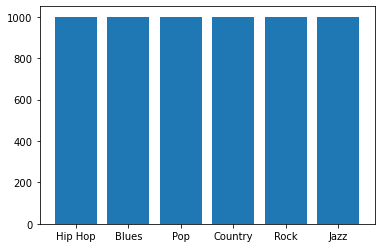

In [13]:
# Display distribution of songs per genre

labels_set = set(combined_genre_data.Genres)
labels_count = []
for label in labels_set:
    labels_count.append(list(combined_genre_data.Genres).count(label))
plt.bar(list(labels_set), labels_count)
plt.show()

In [25]:
def train_and_pipeline(lyrics):
    # Split the data 75% training and 25% testing
    X_train, X_test, y_train, y_test = train_test_split(lyrics, combined_genre_data.Genres, test_size=0.25) 
    
    pipe_MNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', MultinomialNB())
                       ])
    
    pipe_CNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', ComplementNB())
                       ])

    pipe_RF = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', RandomForestClassifier())
                       ])

    pipe_KNN = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', KNeighborsClassifier())
                       ])

    pipelines = [pipe_MNB, pipe_CNB, pipe_RF, pipe_KNN]
    pipeline_names = ['Multinomail NB', 'Complement NB', 'Random Forest', "KNN"]

    # Show pipeline structure
    for pipe in pipelines:
        print(pipe)
        pipe.fit(X_train, y_train)

    # Compare scores
    lemmed_basic_scores = []
    for index, val in enumerate(pipelines):
        tup = (pipeline_names[index], val.score(X_test, y_test))
        lemmed_basic_scores.append(tup)
        print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))
        
    return lemmed_basic_scores

In [26]:
results = Counter()
lyrics_list = list(combined_genre_data.Lyric)
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
english = list(set(nltk.corpus.words.words()))
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In pre-processing our lyrics data, we applied text normalization techniques. We utilized a regexp pattern to remove unnecessary characters from the lyrics list, lower-cased all of the words, and removed stop words based on an english stop words list. We also compared the results of using a WordNetLemmatizer for lemmatization of words with the SnowballStemmer for stemming words. As our lyrics contain overly sparse data, either technique is necessary to curb sparsity and reduce overfitting. We compared combinations of both text normalization techniques on various base supervised classification models. Once the text was normalized, we tokenized the data by splitting lyrics by spaces.

The following two sections explores the effects of lemmatization and stemming.

## Lemmatization

In [121]:
def clean_lyrics_lemma(lyrics_list):
    cleaned = []
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_lemmas)
        cleaned.append(c)
    return cleaned

In [122]:
%%capture
lemmed_lyrics = clean_lyrics_lemma(lyrics_list)

In [63]:
%%capture
lyrics_lengths = [len(lyrics.split()) for lyrics in lemmed_lyrics]

Text(0.5, 0, 'Number of Lyrics')

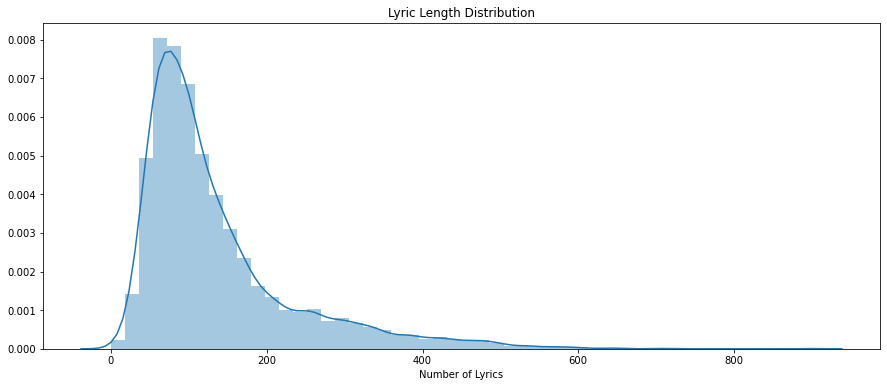

In [64]:
# Display lyric length distribution

sns.distplot(lyrics_lengths)
plt.gcf().set_size_inches(15, 6)
plt.title("Lyric Length Distribution")
plt.xlabel("Number of Lyrics")

We can see that the number of lyrics are unimodal.
Although we filtered out songs with no or null lyrics, during the process of preprocessing as described above, there were some songs which had all their lyrics removed.

Next we explore the length of lyrics for each genre, as well as the number of unique words per genre.

In [47]:
# Compute data for song lyric metrics for each genre

genre_lyrics_length  = []
genre_unique_words = []
for label in labels_set:
    label_index_list = [i for i in range(len(list(combined_genre_data.Genres))) if  list(combined_genre_data.Genres)[i] == label]
    lyrics_len = []
    lyrics_set = set()
    for index in label_index_list:
        split_lyrics = lemmed_lyrics[index].split()
        lyrics_len.append(len(split_lyrics))
        for word in split_lyrics:
            lyrics_set.add(word)
    genre_lyrics_length.append(mean(lyrics_len))
    genre_unique_words.append(len(lyrics_set))
        

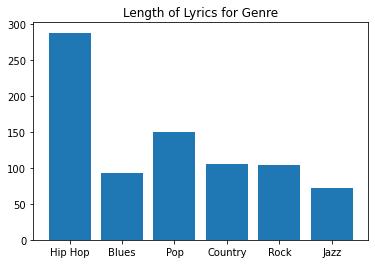

In [50]:
# Display data of lyric length for genre

plt.bar(list(labels_set), genre_lyrics_length)
plt.title('Length of Lyrics for Genre')
plt.show()

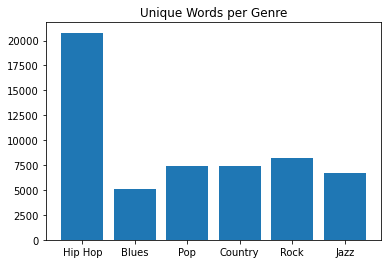

In [51]:
# Display data of unique words per genre

plt.bar(list(labels_set), genre_unique_words)
plt.title('Unique Words per Genre')
plt.show()

In [31]:
results["lemmed"] = train_and_pipeline(lemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.585
Complement NB pipeline test accuracy: 0.589
Random Forest pipeline test accuracy: 0.583
KNN pipeline test accuracy: 0.377


We repeat the preprocessing steps with just stemming, as well as both lemmatization then stemming and stemming them lemmatization, to compare the effects of different preprocessing techniques.

## Stemming

In [32]:
def clean_lyrics_stemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_stemmas = [stemmer.stem(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_stemmas)
        cleaned.append(c)
    return cleaned

In [33]:
stemmed_lyrics = clean_lyrics_stemma(lyrics_list)

In [34]:
results["stemmed"] = train_and_pipeline(stemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.571
Complement NB pipeline test accuracy: 0.585
Random Forest pipeline test accuracy: 0.577
KNN pipeline test accuracy: 0.388


# Stemmed & Lemmatized

In [35]:
lemmatized_stemmed_lyrics = clean_lyrics_lemma(stemmed_lyrics)

In [36]:
results["lemmatized_stemmed"] = train_and_pipeline(lemmatized_stemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.585
Complement NB pipeline test accuracy: 0.591
Random Forest pipeline test accuracy: 0.569
KNN pipeline test accuracy: 0.364


In [37]:
stemmed_lemmatized_lyrics = clean_lyrics_lemma(lemmed_lyrics)

In [38]:
results["stemmed_lemmatized"] = train_and_pipeline(stemmed_lemmatized_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.575
Complement NB pipeline test accuracy: 0.597
Random Forest pipeline test accuracy: 0.566
KNN pipeline test accuracy: 0.362


In [39]:
results

Counter({'lemmed': [('Multinomail NB', 0.5853333333333334),
          ('Complement NB', 0.5893333333333334),
          ('Random Forest', 0.5833333333333334),
          ('KNN', 0.37666666666666665)],
         'stemmed': [('Multinomail NB', 0.5706666666666667),
          ('Complement NB', 0.5853333333333334),
          ('Random Forest', 0.5766666666666667),
          ('KNN', 0.388)],
         'lemmatized_stemmed': [('Multinomail NB', 0.5846666666666667),
          ('Complement NB', 0.5906666666666667),
          ('Random Forest', 0.5693333333333334),
          ('KNN', 0.364)],
         'stemmed_lemmatized': [('Multinomail NB', 0.5746666666666667),
          ('Complement NB', 0.5973333333333334),
          ('Random Forest', 0.566),
          ('KNN', 0.362)]})

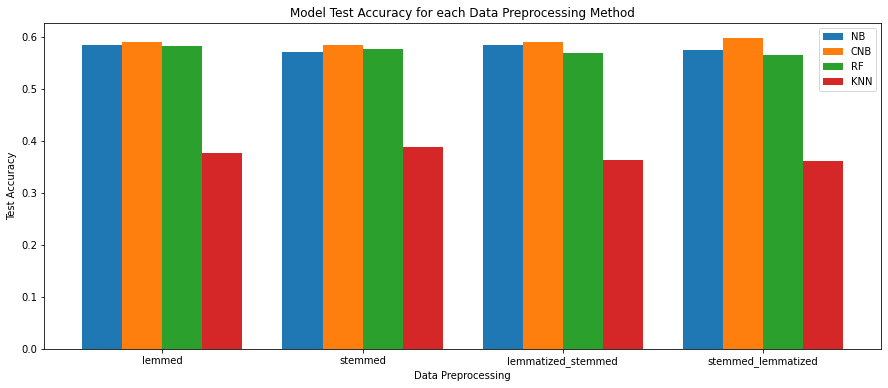

In [40]:
# Compare impact of different preprocessing methods

X = results.keys()

MNB = [results[x][0][1] for x in X]
CNB = [results[x][1][1] for x in X]
RF = [results[x][2][1] for x in X]
KNN = [results[x][3][1] for x in X]

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.3, MNB, 0.2, label = 'NB')
plt.bar(X_axis - 0.1, CNB, 0.2, label = 'CNB')
plt.bar(X_axis + 0.1, RF, 0.2, label = 'RF')
plt.bar(X_axis + 0.3, KNN, 0.2, label = 'KNN')

plt.xticks(X_axis, X)

plt.gcf().set_size_inches(15, 6)
plt.xlabel("Data Preprocessing")
plt.ylabel('Test Accuracy')
plt.title("Model Test Accuracy for each Data Preprocessing Method")
plt.legend()
plt.show()

We found that neither text normalization technique provides a significant improvement in accuracy compared to the other. Lemmatization uses a dictionary defined corpus to supply lemmas for words, while stemming just crops words into their root forms. Generally, lemmatization is the preferred method when the meaning of the word should be retained. As we saw that combining both techniques does not lead to significant improvements and may even reduce performance in some cases, we decided to use lemmatization to pre-process our lyrics data. 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(lemmed_lyrics, combined_genre_data.Genres, test_size=0.25) 

In [74]:
le = LabelEncoder()
le.fit(combined_genre_data.Genres.values)

LabelEncoder()

# Metrics

In [77]:
# Report various metrics for both the training and test sets based on the classified results

def score_report(classes, classified_train, gold_train, classified_test, gold_test):
    print("----------- Training Set Report -----------")
    print("Accuracy", accuracy_score(gold_train, classified_train))
    print("Precision", precision_multi(gold_train, classified_train))
    print("Recall", recall_multi(gold_train, classified_train))
    print("F1", f1_multi(gold_train, classified_train))
    cm = confusion_matrix(gold_train, classified_train, labels=classes)
    print("Confusion matrix", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()
    print("----------- Testing Set Report -----------")
    print("Accuracy", accuracy_score(gold_test, classified_test))
    print("Precision", precision_multi(gold_test, classified_test))
    print("Recall", recall_multi(gold_test, classified_test))
    print("F1", f1_multi(gold_test, classified_test))
    cm = confusion_matrix(gold_test, classified_test, labels=classes)
    print("Confusion matrix", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

In [78]:
# Helper methods to computer various metrics

from collections import Counter
from statistics import mean
def precision_multi_dict(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    classes = set(gold_labels)
    class_precisions = Counter()
    for _class in classes:
        den = 0
        num = 0
        for i in range(len(classified_labels)):
            if classified_labels[i] == _class:
                den += 1
                if gold_labels[i] == _class:
                    num += 1
        if den == 0:
            class_precisions[_class] = 0.0
        else:
            class_precisions[_class] = float(num / den)
    return class_precisions

def precision_multi(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    precision_dict = precision_multi_dict(gold_labels, classified_labels)
    return float(mean(precision_dict.values()))

def recall_multi_dict(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    classes = set(gold_labels)
    class_recalls = Counter()
    for _class in classes:
        den = 0
        num = 0
        for i in range(len(gold_labels)):
            if gold_labels[i] == _class:
                den += 1
                if classified_labels[i] == _class:
                    num += 1
        if den == 0:
            class_precisions[_class] = 0.0
        else:
            class_recalls[_class] = float(num / den)
    return class_recalls

def recall_multi(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    recall_dict = recall_multi_dict(gold_labels, classified_labels)
    return float(mean(recall_dict.values()))

def f1_multi(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    precision_dict = precision_multi_dict(gold_labels, classified_labels)
    recall_dict = recall_multi_dict(gold_labels, classified_labels)

    classes = precision_dict.keys()

    f1_scores = []
    for _class in classes:
        class_precision = precision_dict[_class]
        class_recall = recall_dict[_class]
        if class_precision + class_recall == 0:
            f1_scores.append(0.0)
        else:
            f1_scores.append(float((2 * class_precision * class_recall) / (class_precision + class_recall)))

    return mean(f1_scores)


# Random Forest Classifier

A Random Forest Classifier is an ensemble model that builds multiple decision trees and combines the results to evaluate a feature. The features for this model is a vectorized form of the lyric document input, based on the tf-idf vectorization. Random Forests use a bagging approach and feature randomness to build each individual tree and decrease variance and control overfitting by creating an uncorrelated set of trees. In training this model, we utilized GridSearchCV to find the optimal hyperparameters for `n_estimators`, `criterion`, `max_depth`, `min_samples_split`, and `min_samples_leaf`.

In [22]:
rfc = RandomForestClassifier()

In [23]:
GS_pipe_RF = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', RandomForestClassifier())
                       ])

rf_param_grid = dict(clf__n_estimators = [10, 30, 100, 200],
                  clf__criterion = ['gini', 'entropy'],
                  clf__max_depth = [2, 6, 10, 15], 
                  clf__min_samples_split = [5, 10],
                  clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3)

gs_RF.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [2, 6, 10, 15],
                         'clf__min_samples_leaf': [3, 6],
                         'clf__min_samples_split': [5, 10],
                         'clf__n_estimators': [10, 30, 100, 200]},
             scoring='accuracy')

In [24]:
rf_gs_testing_score = gs_RF.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(rf_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_RF.best_params_))

Mean Testing Score: 57.87%
Best Parameter Combination Found During Grid Search: 
{'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}


----------- Training Set Report -----------
Accuracy 0.7933333333333333
Precision 0.7930759950600708
Recall 0.8143048471659574
F1 0.7945448263582524
Confusion matrix [[617  40   9  38  23  65]
 [ 14 519   3   3  19  13]
 [  7   8 699   2  43   3]
 [ 72 146  17 679  75 115]
 [ 15  22  18   6 512  21]
 [ 25  21  11  20  56 544]]


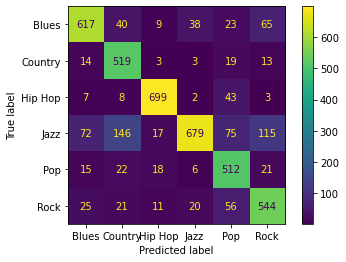

----------- Testing Set Report -----------
Accuracy 0.5786666666666667
Precision 0.57848286831263
Recall 0.5842955403384554
F1 0.564525526449072
Confusion matrix [[164  35   5  17  17  30]
 [ 12  69   1   5  11  21]
 [  3   7 203   2  30   6]
 [ 34  65  12 210  43  60]
 [ 12  35  16   4 129  29]
 [ 25  33   6  14  42  93]]


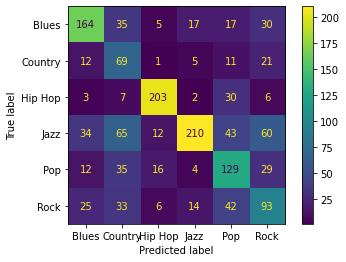

In [53]:
rf_classified_train = gs_RF.predict(X_train)
rf_classified_test = gs_RF.predict(X_test)
score_report(le.classes_, np.array(y_train), rf_classified_train, np.array(y_test), rf_classified_test)

# Multinomial Naive Bayes

The Multinomial Naive Bayes model is an implementation of a Naive Bayes classifier for multi-class settings. This model works well for classification with discrete features; in our case of text classification, fractional counts in the tf-idf values are used as the feature set. The Naive Bayes model works by assuming independence among the features in each classification. The model calculates the prior probabilities of each class based on the counts of the total number of documents, along with the likelihood probability of each sentence token. Then, the probabilities are calculated that the sentence (tf-idf vector) belongs to each class, using the naive bayes equation, and the highest probability is selected in evaluation. 

$$cNB = argmax( p(c) * Πp(f|c) )$$

To handle unseen data in a specific class, MultinomialNB uses an alpha hyperparameter for smoothing techniques such as LaPlace smoothing. We utilized GridSearchCV to optimally select the alpha hyperparameter value, based on the evaluation on the training data. 

In [25]:
GS_pipe_MNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', MultinomialNB())
                       ])

sorted(GS_pipe_MNB.get_params().keys())

mnb_param_grid = dict(clf__alpha = [.01, .05, .1, .2, .4, 1])

gs_MNB = GridSearchCV(estimator=GS_pipe_MNB,
            param_grid=mnb_param_grid,
            scoring='accuracy',
            cv=3)

gs_MNB.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.4, 1]},
             scoring='accuracy')

In [26]:
mnb_gs_testing_score = gs_MNB.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(mnb_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_MNB.best_params_))

Mean Testing Score: 62.6%
Best Parameter Combination Found During Grid Search: 
{'clf__alpha': 0.05}


----------- Training Set Report -----------
Accuracy 0.92
Precision 0.9203334250840227
Recall 0.9235330211483594
F1 0.9203441269913282
Confusion matrix [[698  16   3  28   8  34]
 [ 11 692   6  12   6  16]
 [  2   1 702   2   3   4]
 [ 19  13   1 695   8  10]
 [ 17  32  41   9 698  42]
 [  3   2   4   2   5 655]]


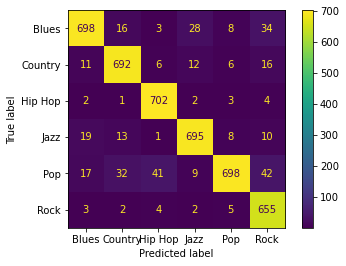

----------- Testing Set Report -----------
Accuracy 0.626
Precision 0.6250922527936705
Recall 0.6334102482346995
F1 0.6256787679292457
Confusion matrix [[173  31   0  17  15  23]
 [ 28 145  11  35  27  51]
 [  2   4 195   7  19  10]
 [ 12  16   0 166  11  12]
 [ 16  34  30  14 167  50]
 [ 19  14   7  13  33  93]]


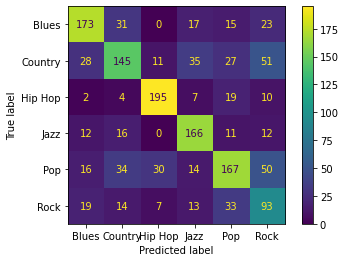

In [54]:
mnb_classified_train = gs_MNB.predict(X_train)
mnb_classified_test = gs_MNB.predict(X_test)
score_report(le.classes_, np.array(y_train), mnb_classified_train, np.array(y_test), mnb_classified_test)

# Complement Naive Bayes

This model is an adaptation of the Multinomial Naive Bayes model, but it is better suited for running on datasets with large imbalances. Since our data has a lack of imbalances, the model does not work as well as the other models.

In [27]:
GS_pipe_CNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', ComplementNB())
                       ])

sorted(GS_pipe_CNB.get_params().keys())

cnb_param_grid = dict(clf__alpha = [.01, .05, .1, .2, .4, 1])

gs_CNB = GridSearchCV(estimator=GS_pipe_CNB,
            param_grid=cnb_param_grid,
            scoring='accuracy',
            cv=3)

gs_CNB.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', ComplementNB())]),
             param_grid={'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.4, 1]},
             scoring='accuracy')

In [28]:
cnb_gs_testing_score = gs_CNB.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(cnb_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_CNB.best_params_))

Mean Testing Score: 59.07%
Best Parameter Combination Found During Grid Search: 
{'clf__alpha': 0.4}


----------- Training Set Report -----------
Accuracy 0.8853333333333333
Precision 0.885500922357269
Recall 0.8902874889725286
F1 0.8849522804405776
Confusion matrix [[688  43   5  28  21  54]
 [  7 629   5   7   9  19]
 [  7  10 724   2  39  17]
 [ 29  29   1 702  17  18]
 [ 17  42  20   7 638  50]
 [  2   3   2   2   4 603]]


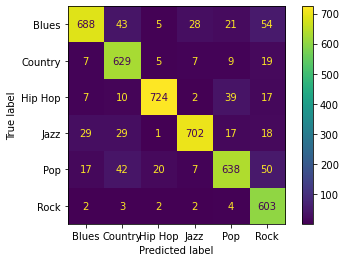

----------- Testing Set Report -----------
Accuracy 0.5906666666666667
Precision 0.5898620484184615
Recall 0.5753158952899737
F1 0.5698445463780064
Confusion matrix [[184  37   2  22  25  35]
 [ 14 114   4  19  23  48]
 [ 10  14 214   9  40  31]
 [ 21  27   3 183  24  27]
 [ 12  41  15  12 138  45]
 [  9  11   5   7  22  53]]


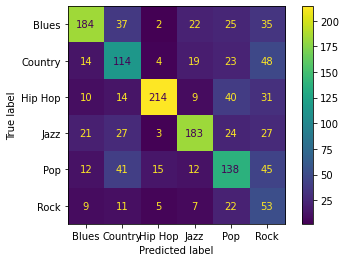

In [55]:
cnb_classified_train = gs_CNB.predict(X_train)
cnb_classified_test = gs_CNB.predict(X_test)
score_report(le.classes_, np.array(y_train), cnb_classified_train, np.array(y_test), cnb_classified_test)

# KNN Classifier

K Nearest Neighbors is a simple supervised learning classifier that uses k-nearest neighbors voting to evaluate a feature. In a KNN model, the features (tf-idf vectors) are mapped to an n-dimensional space. When a feature needs to be evaluated, the class is selected based on the classes of the features closest to the feature in question. The distance metric and the number of nearest neighbors are both hyperparameters set when training the model. We utilized GridSearchCV to select optimal hyperparameters for `n_neighbors` and `p` (distance metric). 

In [29]:
GS_pipe_KNN = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                        ('clf', KNeighborsClassifier())
                        ])

knn_param_grid = dict(clf__n_neighbors = [100, 150, 200],
                     clf__p = [1, 2])

gs_KNN = GridSearchCV(estimator=GS_pipe_KNN,
            param_grid=knn_param_grid,
            scoring='accuracy',
            cv=3)

gs_KNN.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': [100, 150, 200], 'clf__p': [1, 2]},
             scoring='accuracy')

In [30]:
knn_gs_testing_score = gs_KNN.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(knn_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_KNN.best_params_))

Mean Testing Score: 45.2%
Best Parameter Combination Found During Grid Search: 
{'clf__n_neighbors': 150, 'clf__p': 2}


----------- Training Set Report -----------
Accuracy 0.4797777777777778
Precision 0.4814582420937619
Recall 0.5456317909894387
F1 0.4481873897266276
Confusion matrix [[582 233  45 201 135 246]
 [ 35 235   7 107  38 102]
 [  9  20 561  14  47  35]
 [ 18  32   4 263  20  31]
 [100 232 134 156 479 308]
 [  6   4   6   7   9  39]]


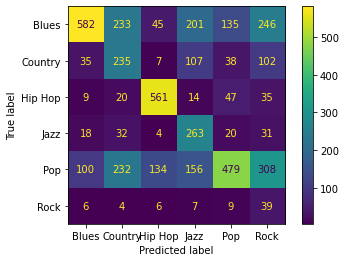

----------- Testing Set Report -----------
Accuracy 0.452
Precision 0.447068313146174
Recall 0.5122279348240688
F1 0.41890972810294863
Confusion matrix [[196  81  20  68  66  67]
 [ 11  50   4  35   8  37]
 [  1   6 167   4  12   9]
 [  4  17   3  87  18   6]
 [ 37  87  48  54 165 107]
 [  1   3   1   4   3  13]]


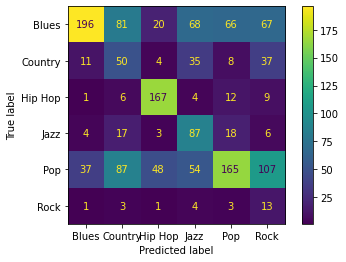

In [56]:
knn_classified_train = gs_KNN.predict(X_train)
knn_classified_test = gs_KNN.predict(X_test)
score_report(le.classes_, np.array(y_train), knn_classified_train, np.array(y_test), knn_classified_test)

# LSTM Neural Net

The last model we built is a Recurrent Neural Network with an Embedding and LSTM layer. The RNN architecture requires that each input vector be of the same size. Based on our exploratory data analysis, we decided to set a max token sequence length of 150, and pad our lyric tokens after performing tokenization (keras Tokenizer) so that each lyric input is of this length; we also utilized one-hot encoding to convert our output labels. The input data tensor is of size (6000, 150), and the output labels tensor is of size (6000, 6). 

The first layer in our model is an Embedding layer [3] which is used to turn tokenized sentence vectors into meaningful dense vectors of a fixed size. We chose an embedding vector of size 100. The advantage of this layer is dimensionality reduction and reducing sparsity in our input data. 
We set 25000 to be the vocab size of the Embedding layer based on unique tokens in our lyrics data; this layer converts the input text with 150 tokens to a dense vector of size 100, based on where words are located in a vector space. 

The LSTM layer in the model is used for memorizing patterns in text data, and solving the vanishing gradient problem. LSTM can memorize sequences in data, which is important for text classification, as there could be common sequences in lyrics of songs in the same genres. Moreover, text data consists of significant unused information, which LSTM can eliminate.

In [65]:
X = lemmed_lyrics
y = combined_genre_data.Genres

In [84]:
MAX_NB_WORDS = 25000
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(lemmed_lyrics)
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 28831 unique tokens.


In [85]:
X = tokenizer.texts_to_sequences(lemmed_lyrics)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (6000, 150)


In [86]:
y = pd.get_dummies(combined_genre_data.Genres).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (6000, 6)


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4500, 150)
(1500, 150)
(4500, 6)
(1500, 6)


In [88]:
model = keras.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

epochs = 10
batch_size = 100

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 100)          2500000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 150, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 606       
Total params: 2,581,006
Trainable params: 2,581,006
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
41/41 [==============================] - 31s 707ms/step - loss: 1.7808 - accuracy: 0.1943 - val_loss: 1.5967 - val_accuracy: 0.3333
Epoch 2/10
41/41 [==============================] - 33s 796ms/step - loss: 1.5321 - accuracy: 

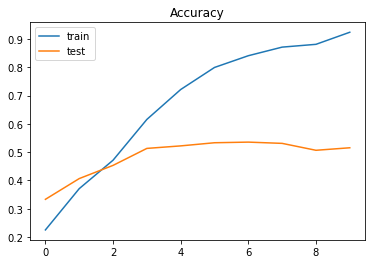

In [89]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [90]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_pred_classes_train = y_pred_train.argmax(axis=-1)
classified_train = le.inverse_transform(y_pred_classes_train)

y_train_classes = y_train.argmax(axis=-1)
gold_train = le.inverse_transform(y_train_classes)

y_pred_classes_test = y_pred_test.argmax(axis=-1)
classified_test = le.inverse_transform(y_pred_classes_test)

y_test_classes = y_test.argmax(axis=-1)
gold_test = le.inverse_transform(y_test_classes)

----------- Training Set Report -----------
Accuracy 0.9022222222222223
Precision 0.9023466103571102
Recall 0.903412471184084
F1 0.9019714191129371
Confusion matrix [[712  34   6   8  20  62]
 [ 12 661   3  25  18  28]
 [  2   2 732   2  28   7]
 [  5  14   5 683  10  13]
 [ 13  21  14   5 638  27]
 [ 11  14   3  11  17 634]]


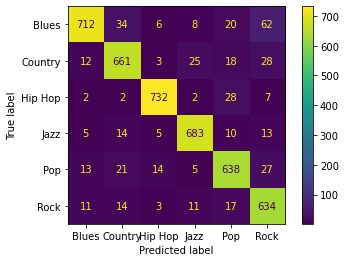

----------- Testing Set Report -----------
Accuracy 0.5313333333333333
Precision 0.5315692237378368
Recall 0.5297392166049795
F1 0.5273970402882646
Confusion matrix [[162  47   3  27  29  49]
 [ 27 102  10  45  41  48]
 [  3   6 192   1  28  12]
 [ 21  38   3 158   9  29]
 [  7  31  21   6 118  26]
 [ 25  30   8  29  44  65]]


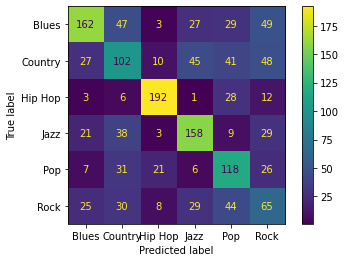

In [91]:
score_report(le.classes_, gold_train, classified_train, gold_test, classified_test)

# Results

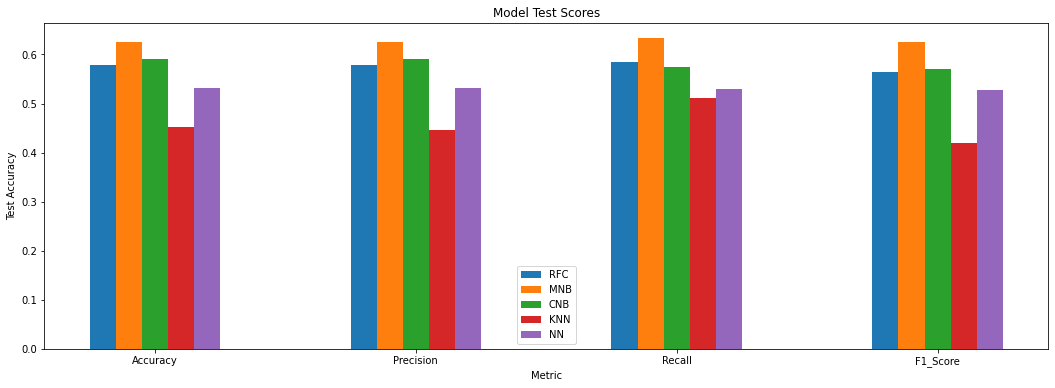

In [106]:
# Display the model results i
model_results = {'RFC': [.579, .578, .584, .565],
                'MNB': [.626, .625, .633, .626],
                'CNB': [.591, .590, .575, .570],
                'KNN': [.452, .447, .512, .419],
                'NN': [.531, .532, .530, .527]}

X = ['Accuracy', 'Precision', 'Recall', 'F1_Score']

RFC = model_results['RFC']
MNB = model_results['MNB']
CNB = model_results['CNB']
KNN = model_results['KNN']
NN = model_results['NN']

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, RFC, 0.1, label = 'RFC')
plt.bar(X_axis - 0.1, MNB, 0.1, label = 'MNB')
plt.bar(X_axis, CNB, 0.1, label = 'CNB')
plt.bar(X_axis + 0.1, KNN, 0.1, label = 'KNN')
plt.bar(X_axis + 0.2, NN, 0.1, label = 'NN')

plt.xticks(X_axis, X)

plt.gcf().set_size_inches(18, 6)
plt.xlabel("Metric")
plt.ylabel('Test Accuracy')
plt.title("Model Test Scores")
plt.legend()
plt.show()

From all of the models, the Multinomial Naive Bayes performed best on the test set, followed by the similar Complement Naive Bayes. The Naive Bayes models are well suited for text classification, due to the independence assumption in Bayes Theorem. A test accuracy score of 62.6% is moderately strong for a multi-class classification problem with 6 labels. A problem observed in our models is overfitting, as the MultinomialNB model had a training accuracy of 92% and significantly less on the test set. A reasoning behind this could be the number of unseen word tokens in the test set. As the vocabulary in Naive Bayes is built from the training set, many words in the test set could be unseen and dropped completely, leading to inaccurate evaluations. The Random Forest Classifier also performed fairly well, and showed less signs of overfitting. This is due to the fact that the RFC is an ensemble classifier, designed to reduce overfitting. The KNN classifier performed worse overall, both on the test and training sets. This model does not base evaluations on probability, so the sparsity of the input tf-idf vectors could cause bad results.

Our hypothesis was that the LSTM Neural Net model would outperform the others. However, the inaccuracy could be due to the lack of strong word embeddings, or incorrect architecture in the model. Adding more layers, such as another LSTM could improve the model’s accuracy on the test data. The following chart shows the accuracy development of the LSTM Neural Net per epoch. The training accuracy increased, while the test accuracy stagnated after the 4th epoch. In this case, lowering the number of epochs used could lead to less overfitting. 

Another way that we could improve our models performance and reduce overfitting is by increasing the size of the training dataset. We only utilized 6000 song lyrics to train our models, but adding more data could help models perform better as they learn more information. 

# Word Cloud

We visualize the impact of key words in each genre through a word cloud.

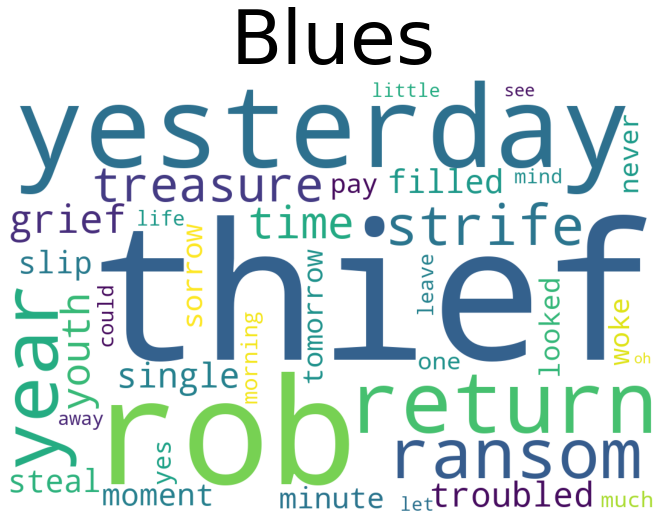

In [137]:
# Split the dataframe into a dictionary of dataframes for each genre
dfs_split_by_genre = {label:combined_genre_data[combined_genre_data.Genres == label] for label in labels}

# Then extract the lyrics into a list for each seperate genre
lyrics_split_by_genre = {label:clean_lyrics_lemma(list(dfs_split_by_genre[label].Lyric)) for label in labels}

# Create a word cloud for each genre
for key in lyrics_split_by_genre:
    # Tokenize the lyrics
    lemmed_lyrics_tokenized = [nltk.word_tokenize(doc) for doc in lyrics_split_by_genre[key]]
    
    # Use the gensim Dictionary to convert the corpus of tokenized lyrics into ids and counts
    dictionary = gensim.corpora.Dictionary(lemmed_lyrics_tokenized)
    
    # Convert the dictionary into a bag of words
    bow = [dictionary.doc2bow(doc) for doc in lemmed_lyrics_tokenized]
    
    # Use tfidf to calculate the weights based on the term frequency
    tfidf = models.TfidfModel(bow)
    tfidf_weights = tfidf[bow[0]]

    # Get lyric terms from the dictionary and pair with weights
    weights = [(dictionary[weight[0]], weight[1]) for weight in tfidf_weights]
    weights = sorted(weights, key = lambda x: x[1])[-200:]
    weights[-20:]
    
    # Initialize the word cloud
    d = {a: x for a, x in weights}

    wc = WordCloud(
        background_color="white",
        width = 1080,
        height = 720,
    )

    # Plot the wordcloud
    wc.generate_from_frequencies(d)
    plt.figure(figsize = (12, 8))
    plt.imshow(wc)
    plt.title(key, color = "black", fontsize = 75)
    plt.axis("off")
    plt.show()
    break

# Future Work

Future Work
To improve our models, our first step will be to gather a larger dataset. The dataset taken from Kaggle contains a large amount of data that we could have used. We also selected a subset of 6 genres from the 79 available in the dataset. In the future, we would like to see the models’ performances for a larger number of classes. 

Another improvement that could be made to the neural network is to use pre-trained Glove Embeddings to convert the word tokens. Glove or Word2Vec are pre-trained models to build word embeddings from the tokenized vectors. These models are powerful and more accurate than the Embedding layer used in our model, and would definitely improve the accuracy of classification. In our project, we built a small model to fit our smaller dataset; however, with a larger dataset, larger model architectures could be used, including a CNN, or a RNN with GRU units instead of the LSTM. Comparing different and larger neural network architecture performances is a great future exploration. 

# Works Cited

[1]https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres?resource=download&select=artists-data.csv

[2]https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221 

[3]https://keras.io/api/layers/core_layers/embedding/ 

[4]https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

[5]https://radimrehurek.com/gensim/corpora/dictionary.html